In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.sparse
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Lambda, Activation, Embedding, Input, Dense, Reshape, Flatten, Dropout, Multiply, Concatenate, Dot

%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')


In [2]:
class AutoRec:
    def __init__(self):
        self.model = None
        self.history = None

    def compute_masked_loss(self, y_true, y_pred):
        """
        Compute loss between y_true(The true output) and y_pred(The predicted output)
        """
        # ignore the missing value (having value of zero) in loss computation
        mask_true = tf.cast(tf.not_equal(y_true, 0), dtype='float32') 

        error = y_true - y_pred

        se = tf.square(error) * mask_true
        mse = tf.reduce_sum(se) / tf.reduce_sum(mask_true)
        return mse 

    def masked_rmse_loss(self, y_true, y_pred):
       return tf.math.sqrt(self.compute_masked_loss(y_true, y_pred))

    def get_autoencoder_model(self, num_users, latent_dim, regularization):
        # The input in IAutoRec is an item vector - all user ratings given for this item
        # The input in UAutoRec is a user vector - all ratings from this user to all items
        input = Input(shape=(num_users,), name='item_ratings')
        
        # According to the paper, the best activation function order is sigmoid + linear

        # This is the encoded representation of the input - go to lower dimension
        encoded = Dense(latent_dim, activation='sigmoid', name='encoded_items', 
                        kernel_regularizer=keras.regularizers.l2(regularization))(input)

        # This is the lossy reconstruction of the input - go back to the original dimension
        decoded = Dense(num_users, activation='linear', name='reconstructed_items', 
                        kernel_regularizer=keras.regularizers.l2(regularization))(encoded)
        
        model = keras.Model(input, decoded)
        return model

    def fit(self, train_data, validation_split=0.1, latent_dim=500, batch_size=256, epochs=500, regularization=0.001, verbose=1):
        # The data is a item-user matrix if we're building I-AutoRec
        # If U-AutoRec, we except to get an user-item matrix
        rows, columns = train_data.shape
        
        print(f"Fitting AutoRec model with train_data={train_data.shape}, latent_dim={latent_dim}, batch_size={batch_size}, epochs={epochs}, reg={regularization}")

        model = self.get_autoencoder_model(columns, latent_dim, regularization)

        rmsprop = keras.optimizers.RMSprop() # In the paper they used RMSProp
        # The loss function is Masked MSE and the metric function is RMSE
        model.compile(optimizer=rmsprop, loss=self.compute_masked_loss, metrics=[self.masked_rmse_loss])

        history = model.fit(x=train_data, y=train_data,
                                      epochs=epochs,
                                      batch_size=batch_size,
                                      validation_split=validation_split,
                                      verbose=verbose)
        
        self.model = model
        self.history = history
        
        return model
    
        
    def plot_loss_history(self):
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['loss', 'val_loss'], loc='upper left')
        plt.show()
    


### Download and load MovieLens 1M dataset

In [3]:
import requests, zipfile, os
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
zip_name = 'ml-1m.zip'
data_dir = 'ml-1m/'
if not os.path.exists(os.path.join(data_dir, zip_name)):
  r = requests.get(url, allow_redirects=True)
  open(zip_name, 'wb').write(r.content)

  with zipfile.ZipFile(zip_name,"r") as zip_ref:
      zip_ref.extractall()

In [4]:
ratings_file = "ml-1m/ratings.dat"
cols_data = ['user_id', 'item_id', 'rating', 'timestamp']

df_ratings = pd.read_csv(ratings_file, delimiter='::', header=None, names=cols_data)
df_ratings

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


### Split train/test 80%/20%

In [5]:
df_ratings_train, df_ratings_test = train_test_split(df_ratings,
                                     stratify=df_ratings['user_id'],
                                     test_size=0.2)

print(df_ratings_train.shape, df_ratings_test.shape)

(800167, 4) (200042, 4)


In [6]:
# Convert to numpy matrix

# We want to train IAutoRec, so we build a movie-user matrix
# The paper proved that IAutoRec is better than UAutoRec

ratings_train = df_ratings_train.pivot(index='item_id', columns='user_id', values='rating').fillna(0)
ratings_test = df_ratings_test.pivot(index='item_id', columns='user_id', values='rating').fillna(0)

ratings_train = ratings_train.to_numpy()
ratings_test = ratings_test.to_numpy()

print("Train / Test:", ratings_train.shape, ratings_test.shape)


Train / Test: (3678, 6040) (3471, 6040)


### Visualize the model

In [7]:
autorec = AutoRec()

temp_model = autorec.get_autoencoder_model(ratings_train.shape[1], 500, 0.001)
temp_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
item_ratings (InputLayer)    [(None, 6040)]            0         
_________________________________________________________________
encoded_items (Dense)        (None, 500)               3020500   
_________________________________________________________________
reconstructed_items (Dense)  (None, 6040)              3026040   
Total params: 6,046,540
Trainable params: 6,046,540
Non-trainable params: 0
_________________________________________________________________


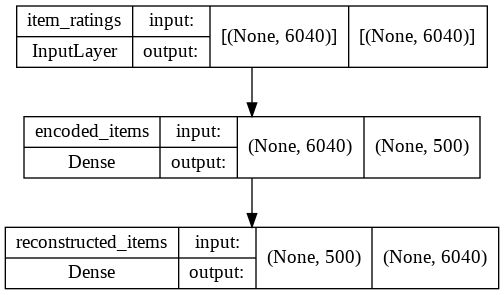

In [ ]:
keras.utils.plot_model(temp_model, show_shapes=True)


### Train test model for 10 epochs

In [8]:
autorec.fit(ratings_train, epochs=10, batch_size=512)


Fitting AutoRec model with train_data=(3678, 6040), latent_dim=500, batch_size=512, epochs=10, reg=0.001
Epoch 1/10
7/7 [==============================] - 1s 26ms/step - loss: 6.8646 - masked_rmse_loss: 1.9543 - val_loss: 2.7245 - val_masked_rmse_loss: 1.0813
Epoch 2/10
7/7 [==============================] - 0s 12ms/step - loss: 2.4260 - masked_rmse_loss: 1.0041 - val_loss: 2.3325 - val_masked_rmse_loss: 1.0511
Epoch 3/10
7/7 [==============================] - 0s 12ms/step - loss: 2.0768 - masked_rmse_loss: 0.9723 - val_loss: 2.0854 - val_masked_rmse_loss: 1.0410
Epoch 4/10
7/7 [==============================] - 0s 12ms/step - loss: 1.8898 - masked_rmse_loss: 0.9825 - val_loss: 1.8814 - val_masked_rmse_loss: 1.0360
Epoch 5/10
7/7 [==============================] - 0s 12ms/step - loss: 1.6816 - masked_rmse_loss: 0.9633 - val_loss: 1.7490 - val_masked_rmse_loss: 1.0352
Epoch 6/10
7/7 [==============================] - 0s 12ms/step - loss: 1.5720 - masked_rmse_loss: 0.9708 - val_loss: 1.6

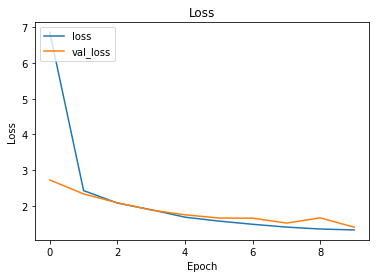

In [9]:
autorec.plot_loss_history()

In [10]:
print("Model RMSE on train:", autorec.history.history['masked_rmse_loss'][-1])
print("Model RMSE on validation:", autorec.history.history['val_masked_rmse_loss'][-1])

Model RMSE on train: 0.9597817659378052
Model RMSE on validation: 1.0113030672073364


In [11]:
test_rmse = autorec.model.evaluate(ratings_test, ratings_test)[1]
print("Model RMSE on test set:", test_rmse)

109/109 [==============================] - 0s 944us/step - loss: 1.7832 - masked_rmse_loss: 1.1839
Model RMSE on test set: 1.1838724613189697


## Hyper-parameter tuning

In [12]:
import time

latent_factors = [10, 40, 80, 100, 200, 400, 500]
batch_sizes = [ 128, 256, 512 ]
regularizations = [0.001, 0.01, 0.1, 1 ]
epochs = 100 # Only one value due to computational power

results = pd.DataFrame(columns=['Epochs', 'Batch size', 'Latent_factors', 'Regularization', 'Validation RMSE', 'Time'])

val_errors = {}
train_errors = {}

model_i = 1

print(f"Training {len(latent_factors) * len(batch_sizes) * len(regularizations)} models for Hyper-parameter tuning...")

for bs in batch_sizes:
  for k in latent_factors:
    for reg in regularizations:
      print(f"Model {model_i}")
      dic = {'Epochs':epochs, 'Latent_factors':k, 'Batch size': bs, 'Regularization':reg}
      
      start = time.time()
      model = autorec.fit(ratings_train, epochs=epochs, batch_size=bs, latent_dim=k, regularization=reg, verbose=0)  
      
      dic['Time'] = time.time() - start
      dic['Validation RMSE'] = autorec.history.history['val_masked_rmse_loss'][-1]

      results = results.append(dic, ignore_index=True)
      model_i += 1 

results


Training 84 models for Hyper-parameter tuning...
Model 1
Fitting AutoRec model with train_data=(3678, 6040), latent_dim=10, batch_size=128, epochs=100, reg=0.001
Model 2
Fitting AutoRec model with train_data=(3678, 6040), latent_dim=10, batch_size=128, epochs=100, reg=0.01
Model 3
Fitting AutoRec model with train_data=(3678, 6040), latent_dim=10, batch_size=128, epochs=100, reg=0.1
Model 4
Fitting AutoRec model with train_data=(3678, 6040), latent_dim=10, batch_size=128, epochs=100, reg=1
Model 5
Fitting AutoRec model with train_data=(3678, 6040), latent_dim=40, batch_size=128, epochs=100, reg=0.001
Model 6
Fitting AutoRec model with train_data=(3678, 6040), latent_dim=40, batch_size=128, epochs=100, reg=0.01
Model 7
Fitting AutoRec model with train_data=(3678, 6040), latent_dim=40, batch_size=128, epochs=100, reg=0.1
Model 8
Fitting AutoRec model with train_data=(3678, 6040), latent_dim=40, batch_size=128, epochs=100, reg=1
Model 9
Fitting AutoRec model with train_data=(3678, 6040), l

,Epochs,Batch size,Latent_factors,Regularization,Validation RMSE,Time
0,100.0,128.0,10.0,0.001,1.198851,7.082947
1,100.0,128.0,10.0,0.010,1.471553,6.942284
2,100.0,128.0,10.0,0.100,1.587839,6.931426
3,100.0,128.0,10.0,1.000,1.607375,6.940115
4,100.0,128.0,40.0,0.001,1.062132,6.952862
...,...,...,...,...,...,...
79,100.0,512.0,400.0,1.000,2.817700,6.634433
80,100.0,512.0,500.0,0.001,1.013941,7.010198
81,100.0,512.0,500.0,0.010,1.196882,7.010034
82,100.0,512.0,500.0,0.100,1.968224,7.025025


In [14]:
results.loc[results['Validation RMSE'].nsmallest(3).index,:]

,Epochs,Batch size,Latent_factors,Regularization,Validation RMSE,Time
20,100.0,128.0,400.0,0.001,0.984837,10.195238
72,100.0,512.0,200.0,0.001,0.991611,5.596724
76,100.0,512.0,400.0,0.001,0.992658,6.607118


In [15]:
def understanding_the_effect(hyper_param):
  y = 'Validation RMSE'
  plt.plot(results.groupby(hyper_param)[y].mean())
  plt.xlabel(hyper_param)
  plt.ylabel(y)
  plt.title(hyper_param)
  plt.show()

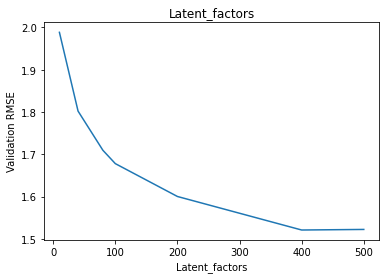

In [16]:
understanding_the_effect("Latent_factors")

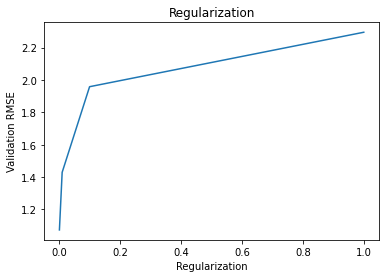

In [17]:
understanding_the_effect("Regularization")

In [18]:
best_params = results.loc[20]
best_params

Epochs             100.000000
Batch size         128.000000
Latent_factors     400.000000
Regularization       0.001000
Validation RMSE      0.984837
Time                10.195238
Name: 20, dtype: float64

In [27]:
# Lets fit the best model
best_model = autorec.fit(ratings_train, 
                          epochs=500,
                          batch_size=int(best_params["Batch size"]),
                          latent_dim=int(best_params["Latent_factors"]),
                          regularization=float(best_params["Regularization"]), verbose=2)  

Fitting AutoRec model with train_data=(3678, 6040), latent_dim=400, batch_size=128, epochs=500, reg=0.001
Epoch 1/500
26/26 - 0s - loss: 3.4438 - masked_rmse_loss: 1.3295 - val_loss: 1.9691 - val_masked_rmse_loss: 1.0442
Epoch 2/500
26/26 - 0s - loss: 1.6616 - masked_rmse_loss: 0.9804 - val_loss: 1.6689 - val_masked_rmse_loss: 1.0554
Epoch 3/500
26/26 - 0s - loss: 1.4158 - masked_rmse_loss: 0.9692 - val_loss: 1.4700 - val_masked_rmse_loss: 1.0300
Epoch 4/500
26/26 - 0s - loss: 1.3133 - masked_rmse_loss: 0.9628 - val_loss: 1.4014 - val_masked_rmse_loss: 1.0212
Epoch 5/500
26/26 - 0s - loss: 1.2692 - masked_rmse_loss: 0.9603 - val_loss: 1.3813 - val_masked_rmse_loss: 1.0244
Epoch 6/500
26/26 - 0s - loss: 1.2370 - masked_rmse_loss: 0.9548 - val_loss: 1.3746 - val_masked_rmse_loss: 1.0269
Epoch 7/500
26/26 - 0s - loss: 1.2254 - masked_rmse_loss: 0.9540 - val_loss: 1.3351 - val_masked_rmse_loss: 1.0155
Epoch 8/500
26/26 - 0s - loss: 1.2109 - masked_rmse_loss: 0.9509 - val_loss: 1.3297 - val

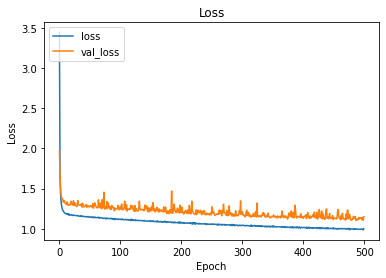

In [28]:
autorec.plot_loss_history()

## Best model Evaluation on test set

In [29]:
test_rmse = autorec.model.evaluate(ratings_test, ratings_test)[1]
print("Best Model RMSE on test set:", test_rmse)

109/109 [==============================] - 0s 939us/step - loss: 1.1406 - masked_rmse_loss: 0.9814
Best Model RMSE on test set: 0.9813743829727173


In [30]:
predicted_test = autorec.model.predict(ratings_test) * (ratings_test == 0)
predicted_test.shape

(3471, 6040)

In [31]:
print("NDCG score:", ndcg_score(ratings_test, predicted_test))

NDCG score: 0.24083372998153887


# Test model on Steam Video Games [dataset](https://www.kaggle.com/tamber/steam-video-games)


This dataset is a list of user behaviors with video games.

The columns: user-id, game-title, behavior-name, value.

The behaviors included are 'purchase' and 'play'.

The value indicates the degree to which the behavior was performed - in the case of 'purchase' the value is always 1, and in the case of 'play' the value represents the number of hours the user has played the game.



## Data loading and Preprocessing

In [32]:
steam_ratings = pd.read_csv('steam-200k.csv', index_col=None, header=None)
steam_ratings.columns=['user_id', 'game', 'action', 'hours', 'none']
steam_ratings = steam_ratings.drop('none', axis=1)

# Group interations by user_id and game
steam_ratings = steam_ratings.groupby(['user_id', 'game'])\
                                      .sum()['hours'].reset_index()

steam_ratings['view'] = 1 
steam_ratings

,user_id,game,hours,view
0,5250,Alien Swarm,5.9,1
1,5250,Cities Skylines,145.0,1
2,5250,Counter-Strike,1.0,1
3,5250,Counter-Strike Source,1.0,1
4,5250,Day of Defeat,1.0,1
...,...,...,...,...
128799,309626088,Age of Empires II HD Edition,7.7,1
128800,309812026,Counter-Strike Nexon Zombies,1.0,1
128801,309812026,Robocraft,1.0,1
128802,309824202,Dota 2,1.7,1


Remove users that had less than 5 interactions

In [33]:
min_interactions = 5
users_interactions_count_df = steam_ratings.groupby('user_id').size()
valid_user_ids = users_interactions_count_df[users_interactions_count_df >= min_interactions].reset_index()[['user_id']]
filtered_ratings = steam_ratings.merge(valid_user_ids, how = 'right', left_on = 'user_id', right_on = 'user_id')
filtered_ratings

,user_id,game,hours,view
0,5250,Alien Swarm,5.9,1
1,5250,Cities Skylines,145.0,1
2,5250,Counter-Strike,1.0,1
3,5250,Counter-Strike Source,1.0,1
4,5250,Day of Defeat,1.0,1
...,...,...,...,...
115134,309404240,AdVenture Capitalist,1.7,1
115135,309404240,Mitos.is The Game,3.2,1
115136,309404240,Team Fortress 2,3.2,1
115137,309404240,Transformice,1.3,1


In [34]:
# Add user ID and item ID fields
filtered_ratings['item_id'] = filtered_ratings['game'].astype('category').cat.codes
filtered_ratings['user_id'] = filtered_ratings['user_id'].astype('category').cat.codes
print("Total users:", filtered_ratings.groupby("user_id").sum("view").shape[0])

filtered_ratings = filtered_ratings[['user_id','item_id','game','hours','view']]
filtered_ratings.head(5)

Total users: 3757


,user_id,item_id,game,hours,view
0,0,226,Alien Swarm,5.9,1
1,0,846,Cities Skylines,145.0,1
2,0,972,Counter-Strike,1.0,1
3,0,978,Counter-Strike Source,1.0,1
4,0,1125,Day of Defeat,1.0,1


Split dataset to 80% Train, 20% Test

In [35]:
# Split dataset in Train/Test
train_df, test_df = train_test_split(filtered_ratings,
                                                 stratify=filtered_ratings['user_id'], 
                                                 test_size=0.2,
                                                 )  
print("Train/test split:", train_df.shape, test_df.shape)
train_df.reset_index(drop=True, inplace=True)

Train/test split: (92111, 5) (23028, 5)


 Create a DataFrame with Content Information

In [36]:
games_df = filtered_ratings.groupby(['game', 'item_id'])\
                                    .agg({'user_id': 'count', 'hours': np.sum})[['user_id','hours']]\
                                    .reset_index()\
                                    .rename(columns={'user_id': 'total_users', 'hours': 'total_hours'})


games_df = games_df[['item_id', 'game','total_users','total_hours']]
games_df

,item_id,game,total_users,total_hours
0,0,007 Legends,1,1.7
1,1,0RBITALIS,3,4.2
2,2,1... 2... 3... KICK IT! (Drop That Beat Like a...,7,27.0
3,3,10 Second Ninja,6,11.9
4,4,"10,000,000",1,4.6
...,...,...,...,...
5108,5108,sZone-Online,95,147.7
5109,5109,samurai_jazz,1,1.0
5110,5110,the static speaks my name,13,15.0
5111,5111,theHunter,220,515.3


In [37]:
# Create a user-item matrix
# For this dataset, we train a U-AutoRec since we only have item properties.

users_items_matrix_train = train_df.pivot(index='user_id', columns='item_id', values='view').fillna(0)
users_items_matrix_test  = test_df.pivot(index='user_id', columns='item_id', values='view').fillna(0)

print("Train set - users,items = ", users_items_matrix_train.shape)
print("Test set - users,items = ", users_items_matrix_test.shape)

Train set - users,items =  (3757, 4837)
Test set - users,items =  (3757, 3286)


In [38]:
# Extend test set to account missing items, set default rating to 0
for i in range(users_items_matrix_train.shape[1] - users_items_matrix_test.shape[1]):
  users_items_matrix_test[users_items_matrix_test.shape[1] + users_items_matrix_test.shape[1]] = 0

users_items_matrix_test.shape

(3757, 4837)

## Model fitting

In [39]:
autorec = AutoRec()

steam_model = autorec.get_autoencoder_model(users_items_matrix_train.shape[1], 500, 0.001)
steam_model.summary()


Model: "model_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
item_ratings (InputLayer)    [(None, 4837)]            0         
_________________________________________________________________
encoded_items (Dense)        (None, 500)               2419000   
_________________________________________________________________
reconstructed_items (Dense)  (None, 4837)              2423337   
Total params: 4,842,337
Trainable params: 4,842,337
Non-trainable params: 0
_________________________________________________________________


In [43]:
steam_model = autorec.fit(users_items_matrix_train, 
                          epochs=100,batch_size=128,latent_dim=500,regularization=0.001)
                         

# RMSE is low because we don't have ratings, we have only binary - clicked/not clicked

Fitting AutoRec model with train_data=(3757, 4837), latent_dim=500, batch_size=128, epochs=100, reg=0.001
Epoch 1/100
27/27 [==============================] - 0s 9ms/step - loss: 0.7086 - masked_rmse_loss: 0.2679 - val_loss: 0.2169 - val_masked_rmse_loss: 0.1464
Epoch 2/100
27/27 [==============================] - 0s 5ms/step - loss: 0.1541 - masked_rmse_loss: 0.1894 - val_loss: 0.1170 - val_masked_rmse_loss: 0.2251
Epoch 3/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0963 - masked_rmse_loss: 0.2021 - val_loss: 0.0702 - val_masked_rmse_loss: 0.1537
Epoch 4/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0792 - masked_rmse_loss: 0.1922 - val_loss: 0.0917 - val_masked_rmse_loss: 0.2348
Epoch 5/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0769 - masked_rmse_loss: 0.2001 - val_loss: 0.0757 - val_masked_rmse_loss: 0.2015
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 0.0728 - masked_rmse_loss: 0.1985 - 

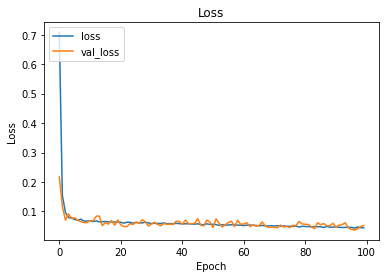

In [44]:
autorec.plot_loss_history()

In [45]:
test_rmse = autorec.model.evaluate(users_items_matrix_test, users_items_matrix_test)[1]
print("Model RMSE on test set:", test_rmse)

118/118 [==============================] - 0s 1ms/step - loss: 0.1117 - masked_rmse_loss: 0.3100
Model RMSE on test set: 0.31003808975219727


In [49]:
predicted_test = autorec.model.predict(users_items_matrix_test) * (users_items_matrix_test == 0)
predicted_test.shape

(3757, 4837)

In [50]:
# converting the reconstructed matrix back to a Pandas dataframe
predicted_users_items_matrix = pd.DataFrame(predicted_test, 
                                          columns = users_items_matrix_test.columns, 
                                          index   = users_items_matrix_test.index)
predicted_users_items_matrix.head()

item_id,0,1,2,3,5,7,8,9,10,12,...,9654,9656,9658,9660,9662,9664,9666,9668,9670,9672
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.571299,0.923085,0.778819,0.337464,0.811846,0.467272,0.684150,0.715160,1.048577,0.893061,...,0.921841,0.754351,1.004673,0.972114,0.786813,0.876833,1.113575,1.280500,1.095377,0.952507
1,0.571103,0.922634,0.778494,0.337418,0.811490,0.467187,0.683906,0.714874,1.048021,0.892629,...,0.921330,0.754001,1.004021,0.971624,0.786359,0.876358,1.112760,1.279711,1.094487,0.952022
2,0.571424,0.923374,0.779028,0.337493,0.812074,0.467326,0.684306,0.715343,1.048933,0.893338,...,0.922169,0.754575,1.005090,0.972428,0.787104,0.877137,1.114097,1.281005,1.095948,0.952817
3,0.571120,0.922673,0.778522,0.337422,0.811521,0.467195,0.683927,0.714899,1.048069,0.892667,...,0.921374,0.754031,1.004077,0.971667,0.786399,0.876399,1.112831,1.279780,1.094564,0.952064
4,0.571224,0.922914,0.778696,0.337446,0.811710,0.467239,0.684057,0.715051,1.048365,0.892897,...,0.921646,0.754218,1.004424,0.971928,0.786640,0.876652,1.113265,1.280200,1.095038,0.952322


## Model Evaluation on test set

In [52]:
from sklearn.metrics import ndcg_score


print("NDCG score:", ndcg_score(users_items_matrix_test, predicted_test))

NDCG score: 0.12640886294408438
